# <font color=red> **Time series clustering on full data** </font>

## Parameter locations:

- Global Inputs
- data_process
- dtw_dist_matrix
- get_distance_matrix

- n[i] is number of observations in cluster i

# Libraries

In [1]:
import random
import sys
import copy
import sys 
import math
import statsmodels.api as sm
import numpy as np 
import pandas as pd
import itertools
import os
import time
import seaborn as sns
import warnings

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

from datetime import datetime
from numpy.random import multinomial
from statsmodels.distributions.mixture_rvs import mixture_rvs
from random import randrange
from statistics import mean
from statistics import median
from math import sqrt
from math import pow
from math import log2
from bisect import bisect_left

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", ClusterWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
mpl.rc('figure', max_open_warning = 0)

# Print start time

In [2]:
start  = datetime.now()
start_string = str(start.strftime("%d-%m-%Y_%H_%M"))

In [3]:
folder_name = "Clustering_Full_"+ start_string
file_extension = ".txt"
file_name =  "Clustering_Full_"+ start_string + file_extension
os.mkdir(folder_name)
os.chdir(folder_name)

# Text append function

In [4]:
file_object = open(file_name, 'w')

def append_prints(file_name, text_to_append):
    """Append given text as a new line at the end of file"""
    
    # Open the file in append & read mode ('a+')
    
    with open(file_name, "a+") as file_object:

        file_object.seek(0)
        data = file_object.read(100)
        
        if len(data) > 0:
            file_object.write("\n")
            
        file_object.write(text_to_append)
file_object.close()

# Global Inputs

In [5]:
prob_trash = 0.000000001
prob_fill = 0.00000001
K_max = 20              # change here
N = 366                  # change here 366
d = 1                   # change here

# Data loading and processing

- Start time and end time needs to be specified here
- Finucane road data is used for morning peak

In [6]:
data1 = pd.read_csv(r"C:\Users\n10387684\OneDrive - Queensland University of Technology\1_QUT\Codes\GitHub\TTR_AS\Data_Finucane road\TT_all_day_morning.csv")

In [7]:
# View data
dddd = data1.drop(data1.iloc[:, 0:2], axis=1)
dddd = dddd.T
dddd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,1/01/2020,WEDNESDAY,3.93,3.93,3.94,3.98,3.95,4.04,4.05,4.12,4.16,4.24,4.27,4.29
2,2/01/2020,THURSDAY,4.25,4.4,4.56,4.74,4.65,4.72,4.89,5.14,5.02,5.02,5.37,5.6
3,3/01/2020,FRIDAY,4.27,4.37,4.59,4.62,4.78,4.84,4.97,5.17,5.31,5.03,5.59,5.5
4,4/01/2020,SATURDAY,4.11,3.96,4.13,4.04,4.16,4.22,4.36,4.37,4.59,4.68,4.69,4.83
5,5/01/2020,SUNDAY,3.83,3.85,3.87,4.04,3.94,4.06,4.08,4.17,4.27,4.37,4.34,4.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,27/12/2020,SUNDAY,3.95,4.07,4.07,4.03,4.18,4.18,4.3,4.26,4.46,4.67,4.73,4.95
363,28/12/2020,MONDAY,4.05,4.09,4.08,4.16,4.19,4.1,4.3,4.45,4.39,4.7,4.74,5.02
364,29/12/2020,TUESDAY,4.38,4.4,4.44,4.56,4.61,4.56,4.71,4.79,4.9,5.34,5.39,5.47
365,30/12/2020,WEDNESDAY,4.22,4.35,4.54,4.42,4.39,4.54,4.69,4.66,4.89,5.15,5.23,5.39


In [8]:
def data_process(data):

    data2 = pd.DataFrame(data) #Converting data to dataframe
    data3 = data2.drop([0, 1]) # Removing first two rows
    data4 = data3.drop(data3.iloc[:, 0:2], axis=1) # Dropping first three columns
    data5 = data4.T
    
    #convert dataframe to array
    data6 = data5.to_numpy(dtype=float)
    data7 = data6.copy()
    df = data7*60
    df = df[:,0:12] # change here to consider range of time intervals; example 0:12 is to consider all time intervals

    print('Data loaded')
    
    return df

# Dynamic Time Wrapping

In [9]:
def dtw_day(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [10]:
def dtw_dist_matrix(df): # df is a multi array

    dtw_list = []
    values = []
    start_day_dtw = []
    end_day_dtw = []
    
    for i in range(len(df)):          ### change here: len(df) or 0,30
        for j in range(len(df)):
            if i>=j:
                q = dtw_day(df[i], df[j])
                values.append(q[len(df[0])][len(df[0])])
                dtw_list.append([i,j,q[len(df[0])][len(df[0])]]) #dtw distance
                start_day_dtw.append(i)
                end_day_dtw.append(j)

    dtw_table_day = pd.DataFrame({'start_day':start_day_dtw, 'end_day':end_day_dtw,'values': values})
    dtw_table_day['Norm_dtw'] = (dtw_table_day['values']-dtw_table_day['values'].min())/(dtw_table_day['values'].max()-dtw_table_day['values'].min())

    dtw_distance_matrix = pd.pivot_table(dtw_table_day, values='Norm_dtw', index=['start_day'], columns=['end_day'], aggfunc='mean')
    dtw_distance_matrix.values[[np.arange(dtw_distance_matrix.shape[0])]*2] = 0
    dtw_distance_matrix = dtw_distance_matrix.fillna(0.0)
    dtw_distance_matrix = dtw_distance_matrix.to_numpy()
    dtw_distance_matrix = dtw_distance_matrix + dtw_distance_matrix.T
    dtw_distance_matrix = pd.DataFrame(dtw_distance_matrix)
    
    return dtw_distance_matrix, dtw_table_day

# Applying KDE on each day between ti and tj

In [11]:
def kde_day():
    '''
    Info: 
        Kernel density estimation for each day
    Outputs: 
        1) Array of estimated kerner densities where N is the number of day
        2) Array of grid points (interpolated samples) where N is the number of day
        output will have same number of samples for each day and,
        the number would depend on the grid size
    Iterator: 
        i will iterate over days (i in range of 0 to N)
    '''
    density = []
    support = []
    day = []
    
    df = data_process(data1)
    
    for i in range(len(df)):
        
        model = sm.nonparametric.KDEUnivariate(df[i])
        model.fit()

        a = model.density/np.sum(model.density) #Normalizing the estimated density

        density.append(a) #Probability values
        
        support.append(model.support) #Measured quantity i.e., TT in this case
        day.append(i)
   
    print('Day wise Kernel density estimated')
    
    return (density, support, day), df

# Entropy estimation for each pair of day

In [12]:
def compute_entropy_day(df):
    '''
    Info:
        Computes symmetric relative cross entropy between two distributions p and q by taking 
        element wise log ratio for each distribution pairs
    Input: 
        1) Two density arrays p and q of equal size i.e the number of data points should be same
    Output: 
        2) symmetric relative cross entropy
    Iterator:
        i iterates over each point of (p,q)
    '''
    entropy_sum = 0.0
        
    for index, row in df.iterrows():
                
        x = abs(row['probabilityi'] * (np.log((2*row['probabilityi']) / (row['probabilityi'] + row['probabilityj']))))
        y = abs(row['probabilityj'] * (np.log((2*row['probabilityj']) / (row['probabilityi'] + row['probabilityj']))))
        
        entropy = x+y
        entropy_sum += entropy
        
    return entropy_sum

In [13]:
def compute_weight_day(a,b,c,d):
    '''
    Info:
        1) Computes weight for each pair of distributions p and q
        2) Weight captures the divergence on X axis
    Input:
        Min-Max of p and q
    Output: 
        1) Scalar value (weight) for each pairs of p and q
    '''
    ac = abs(c - a)
    bd = abs(d - b)
    ad = abs(max(d,b) - min(a,c))
    
    weight_day = 0
    
    if ad >0:
        weight_day = (ac+bd)/ad
       
    return weight_day

# Get distance matrix

In [14]:
def get_distance_matrix():
    
    pd.options.mode.chained_assignment = None  # default='warn' ignoring the warnings

    (density, support, day), df = kde_day()  ###### KDE execution for each day ###############################
    
    dtw_distance_matrix, dtw_table_day = dtw_dist_matrix(df)   # dtw distance matrix estimation
    dtw_distance_matrix = round(dtw_distance_matrix,2)
    
    density_array=np.array(density)
    TT_array=np.array(support)
    day_array=np.array(day)

# Empty lists to append results ########## Entropy estimation for each pair of day ################
    start_day = []
    end_day = []
    Entropy = []
    condition =[]
    datapoints = []
    
# 'i' and 'j' are to iterate over range of days
    for i in range(len(density_array)): ## Change here len(density_array) or 0,30
        for j in range(len(density_array)):
            
            day_i=pd.DataFrame()
            day_j=pd.DataFrame()

            if i>=j:

                day_i['TT'] = TT_array[i]
                day_i["probabilityi"] =(density_array[i])
                sum1= day_i["probabilityi"].sum()
                day_i["probabilityi"]= day_i["probabilityi"].div(sum1)
                day_i = day_i.round({'TT':0})
                day_j['TT'] = TT_array[j]
                day_j["probabilityj"] =(density_array[j])
                sum2= day_j["probabilityj"].sum()
                day_j["probabilityj"]= day_j["probabilityj"].div(sum2)
                day_j = day_j.round({'TT':0})
                min_valuei = day_i['TT'].min()
                max_valuei = day_i['TT'].max()
                min_valuej = day_j['TT'].min()
                max_valuej = day_j['TT'].max()
                weight_day = compute_weight_day(min_valuei,max_valuei,min_valuej,max_valuej)
## Condition A

                if (max_valuei >= max_valuej) and (min_valuei <= min_valuej): #criteria

                    df_ij = pd.merge(day_i, day_j,  how='left', on=['TT']) #making dataframe with "TT" "probabilityi" and "probabilityj"
                    df_ij['probabilityj'] = df_ij['probabilityj'].fillna(0.00000001) # Filling NaNs with insignificantly small proabbability
                    df_ij=df_ij[(df_ij['probabilityi']>prob_trash) & (df_ij['probabilityj']>prob_trash)]
                    df_ij = df_ij.sort_values(by=['TT'])
                    df_ij = df_ij.reset_index(drop=True)
                    
                    entropy_sum = compute_entropy_day(df_ij)                   
                    sqrt_e_sum = weight_day * sqrt(entropy_sum)
                    
                    rount_sqrt_e_sum = round((1/(round(sqrt_e_sum, 2)+1)),2)

                    start_day.append(i)
                    end_day.append(j)                    
                    Entropy.append(rount_sqrt_e_sum)
                    datapoints.append(len(df_ij['probabilityi']))
                    condition.append(1)
## Condition B

                elif (max_valuej >= max_valuei) and (min_valuej <= min_valuei):    

                    df_ji = pd.merge(day_j, day_i,  how='left', on=['TT'])
                    df_ji['probabilityi'] = df_ji['probabilityi'].fillna(0.00000001)
                    df_ji= df_ji[(df_ji['probabilityi']>prob_trash) & (df_ji['probabilityj']>prob_trash)]
                    
                    df_ji = df_ji.sort_values(by=['TT'])
                    df_ji = df_ji.reset_index(drop=True)

                    entropy_sum = compute_entropy_day(df_ji)
                    sqrt_e_sum = weight_day * sqrt(entropy_sum)
                    
                    rount_sqrt_e_sum = round((1/(round(sqrt_e_sum, 2)+1)),2)

                    start_day.append(i)
                    end_day.append(j)                    
                    Entropy.append(rount_sqrt_e_sum)
                    datapoints.append(len(df_ji['probabilityi']) )                                     
                    condition.append(2)
## Condition C

                elif (max_valuej > max_valuei) and (min_valuei < min_valuej):

                    df_i_j = pd.merge(day_i, day_j,  how='inner', on=['TT'])    

                    day_j1= day_j.loc [(day_j['TT']> max_valuei)]
                    day_j1['probabilityi'] = 0.00000001
                    day_j1 = day_j1[['TT','probabilityi',"probabilityj"]] # rearranging columns
                    day_i1= day_i.loc [(day_i['TT']< min_valuej)]
                    day_i1['probabilityj'] = 0.00000001
                    df_iX = pd.concat([df_i_j, day_j1, day_i1], ignore_index=True)
                    df_iX = df_iX[(df_iX['probabilityi']>prob_trash) & (df_iX['probabilityj']>prob_trash)]
                    
                    df_iX = df_iX.sort_values(by=['TT'])
                    df_iX = df_iX.reset_index(drop=True)

                    entropy_sum = compute_entropy_day(df_iX)
                    sqrt_e_sum = weight_day * sqrt(entropy_sum)

                    rount_sqrt_e_sum = round((1/(round(sqrt_e_sum, 2)+1)),2)
        
                    start_day.append(i)
                    end_day.append(j)                    
                    Entropy.append(rount_sqrt_e_sum)
                    datapoints.append(len(df_iX['probabilityi']) )
                    condition.append(3)
## Condition D

                elif (max_valuei > max_valuej) and (min_valuej < min_valuei):

                    df_j_i = pd.merge(day_i, day_j,  how='inner', on=['TT'])
                    day_j_i = df_j_i[['TT','probabilityi',"probabilityj"]]
                    day_i1= day_i.loc [(day_i['TT']> max_valuej)]
                    day_i1['probabilityj'] = 0.00000001
                    day_j1= day_j.loc [(day_j['TT']< min_valuei)]
                    day_j1['probabilityi'] = 0.00000001
                    day_j1 = day_j1[['TT','probabilityi',"probabilityj"]]
                    day_jY = pd.concat([df_j_i, day_j1, day_i1], ignore_index=True)
                    day_jY = day_jY[(day_jY['probabilityi']>prob_trash) & (day_jY['probabilityj']>prob_trash)]
                    
                    day_jY = day_jY.sort_values(by=['TT'])
                    day_jY = day_jY.reset_index(drop=True)

                    entropy_sum = compute_entropy_day(day_jY)
                    sqrt_e_sum = weight_day * sqrt(entropy_sum)
                    
                    rount_sqrt_e_sum = round((1/(round(sqrt_e_sum, 2)+1)),2)

                    start_day.append(i)
                    end_day.append(j)                    
                    Entropy.append(rount_sqrt_e_sum)
                    datapoints.append(len(day_jY['probabilityi'])   )                
                    condition.append(4)

    Entropy_table_day = pd.DataFrame({'start_day':start_day, 'end_day':end_day,'Entropy': Entropy, 'condition':condition, 'datapoints':datapoints})
    Entropy_table_day['Entropy'] = (Entropy_table_day['Entropy']-Entropy_table_day['Entropy'].min())/(Entropy_table_day['Entropy'].max()-Entropy_table_day['Entropy'].min())
    
#################### Distance Matrix prep ##########################################

    distance_matrix = pd.pivot_table(Entropy_table_day, values='Entropy', index=['start_day'], columns=['end_day'], aggfunc='mean')
    distance_matrix.values[[np.arange(distance_matrix.shape[0])]*2] = 0
    distance_matrix = distance_matrix.fillna(0.0)
    distance_matrix = distance_matrix.to_numpy()
    distance_matrix = distance_matrix + distance_matrix.T
    Entropy_distance_matrix = pd.DataFrame(distance_matrix)
    Entropy_distance_matrix = round(Entropy_distance_matrix,2)
    dist = (Entropy_distance_matrix + dtw_distance_matrix)/2 
    
##############Final Distance Matrix and table #################################################
    dist = round(dist,2)                       
    dist.to_csv('Distance_Matrix.csv')
    
    Dist_table = dist.stack().reset_index()
    Dist_table.columns = ['Day_i','Day_j','Distance'] # Distance table

    print('Distance matrix caclulated')

    return dist, df, dtw_distance_matrix, Entropy_distance_matrix, Entropy_table_day,dtw_table_day, Dist_table

# Applying clustering algorithm

- No of clusters is to be given here

In [15]:
def Hclustering(dist,df, k):  

    clustNum = k
    Hclust = AgglomerativeClustering(linkage='ward', distance_threshold = None, n_clusters = clustNum)
    
    Hclust.fit(dist)
    labels = Hclust.labels_
    n = np.bincount(labels)
    
    print('clustNum: %s' %clustNum)
    print('Hclustering.labels_: %s' %labels)
    print('No of days in each cluster: %s' %n)
    
    append_prints(file_name, 'clustNum: %s' %clustNum)
    append_prints(file_name, 'Hclustering.labels_: %s' %labels)
    append_prints(file_name,'No fo days in each cluster: %s' %n)
    
    return labels, clustNum, dist, df,k, n

In [64]:
labels, clustNum, dist, df,k, n = Hclustering(dist,df, 8)

clustNum: 8
Hclustering.labels_: [6 0 0 1 1 5 2 2 2 2 0 1 2 2 2 2 2 1 1 2 2 2 2 2 0 1 1 3 7 7 7 0 1 3 3 7 7
 3 0 1 3 7 7 7 7 0 1 3 7 7 7 3 0 1 3 7 3 7 3 0 1 7 7 7 7 3 0 1 7 7 7 7 3 0
 1 3 3 3 4 4 0 1 4 4 0 2 2 1 6 5 5 5 5 5 1 6 5 5 5 5 6 1 6 6 5 5 5 5 1 6 5
 2 2 5 2 6 1 2 2 2 2 2 1 1 6 2 2 2 2 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 6 4 4 4
 3 4 0 6 4 4 4 4 4 1 1 4 4 4 4 4 0 1 4 4 4 4 4 0 1 4 4 4 4 4 0 1 2 2 2 2 2
 0 1 2 0 2 0 2 1 1 4 3 3 3 3 0 1 3 3 3 4 3 0 1 3 3 3 4 4 0 1 4 4 4 4 4 0 1
 5 4 4 4 0 0 1 4 3 3 4 4 0 1 4 3 4 4 4 0 1 4 4 4 4 2 0 1 4 3 3 4 4 0 1 4 3
 3 4 4 0 1 2 2 2 2 2 0 1 2 2 2 2 2 0 1 1 3 3 3 3 0 1 3 3 3 3 4 0 1 4 3 3 3
 3 0 1 7 3 3 3 3 0 1 3 3 3 3 4 0 1 3 3 3 3 3 0 1 3 3 3 3 3 0 1 3 3 3 3 3 0
 1 3 3 3 3 4 0 1 4 4 4 2 2 0 1 2 2 2 2 0 0 1 0 0 0 0 1 1 1 1 0 0 0]
No of days in each cluster: [62 63 53 73 64 17 11 23]


# Extracting data of each cluster

In [16]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy
    return np.where(labels_array == clustNum)[0]

In [17]:
def get_Clustered_data(df, dist, k):
    
    Clustered_data = []
    
    labels, clustNum, dist, df,k, n = Hclustering(dist, df , k)
    
    for i in range(0, clustNum):
        X = df[ClusterIndicesNumpy(i, labels)]
        flat_list = [item for sublist in X for item in sublist]
        Clustered_data.append(flat_list)
    
    return Clustered_data, labels, clustNum, dist, df, k, n

In [65]:
Clustered_data, labels, clustNum, dist, df, k, n = get_Clustered_data(df, dist, 8)

clustNum: 8
Hclustering.labels_: [6 0 0 1 1 5 2 2 2 2 0 1 2 2 2 2 2 1 1 2 2 2 2 2 0 1 1 3 7 7 7 0 1 3 3 7 7
 3 0 1 3 7 7 7 7 0 1 3 7 7 7 3 0 1 3 7 3 7 3 0 1 7 7 7 7 3 0 1 7 7 7 7 3 0
 1 3 3 3 4 4 0 1 4 4 0 2 2 1 6 5 5 5 5 5 1 6 5 5 5 5 6 1 6 6 5 5 5 5 1 6 5
 2 2 5 2 6 1 2 2 2 2 2 1 1 6 2 2 2 2 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 6 4 4 4
 3 4 0 6 4 4 4 4 4 1 1 4 4 4 4 4 0 1 4 4 4 4 4 0 1 4 4 4 4 4 0 1 2 2 2 2 2
 0 1 2 0 2 0 2 1 1 4 3 3 3 3 0 1 3 3 3 4 3 0 1 3 3 3 4 4 0 1 4 4 4 4 4 0 1
 5 4 4 4 0 0 1 4 3 3 4 4 0 1 4 3 4 4 4 0 1 4 4 4 4 2 0 1 4 3 3 4 4 0 1 4 3
 3 4 4 0 1 2 2 2 2 2 0 1 2 2 2 2 2 0 1 1 3 3 3 3 0 1 3 3 3 3 4 0 1 4 3 3 3
 3 0 1 7 3 3 3 3 0 1 3 3 3 3 4 0 1 3 3 3 3 3 0 1 3 3 3 3 3 0 1 3 3 3 3 3 0
 1 3 3 3 3 4 0 1 4 4 4 2 2 0 1 2 2 2 2 0 0 1 0 0 0 0 1 1 1 1 0 0 0]
No of days in each cluster: [62 63 53 73 64 17 11 23]


# Kernel density estimation for clusters

In [18]:
def kde(df, dist, k):
    '''
    Info: 
        Kernel density estimation for each cluster
    Inputs: 
        1) start time (ti), 
        2) end time (tj) , 
        3) (n,k) Array where samples of cluster i are at index i and, 
        shape of input array = (ni,K) where n is the number of samples in cluster i
    Outputs: 
        1) (K,n) Array of estimated kerner densities where K is the number of clusters
        2) (K,n) Array of grid points (interpolated samples) where K is the number of clusters
        output will have same number of samples for each cluster and,
        the number would depend on the grid size
    Iterator: 
        i will iterate over clusters (i in range of 0 to n-k)
    '''
    density = []
    support = []
    
    Clustered_data, labels, clustNum, dist, df,k,n = get_Clustered_data(df, dist, k)
    
    for i in range(len(Clustered_data)): #DF
        
        model = sm.nonparametric.KDEUnivariate(Clustered_data[i]) #DF
        model.fit()

        a = model.density/np.sum(model.density) #Normalizing the estimated density

        density.append(a) #Probability values
        support.append(model.support) #Measured quantity i.e., TT in this case    
    
    return density, support, Clustered_data, labels, clustNum, dist, df, k, n

In [19]:
def get_density(df, dist,k):
    '''
    Executes kde and returns density estimates along with support for each cluster   
    '''
    density, support, Clustered_data, labels, clustNum, dist, df, k,n = kde(df, dist, k) # full data is loaded and slicing is done in the KDE function
    
    C_density_array=np.array(density)
    C_TT_array=np.array(support)

    return C_density_array, C_TT_array, Clustered_data, labels, clustNum, dist, df, k,n

# Cluster Entropy estimation

In [20]:
def compute_entropy(df):
    '''
    Info:
        Computes symmetric relative cross entropy between two distributions p and q by taking 
        element wise log ratio for each distribution pairs
    Input: 
        1) Two density arrays p and q of equal size i.e the number of data points should be same
    Output: 
        2) symmetric relative cross entropy
    Iterator:
        i iterates over each point of (p,q)
    '''
    entropy_sum = 0.0
    
    for index, row in df.iterrows():

        x = abs(row['probabilityi'] * (np.log((2*row['probabilityi']) / (row['probabilityi'] + row['probabilityj']))))
        y = abs(row['probabilityj'] * (np.log((2*row['probabilityj']) / (row['probabilityi'] + row['probabilityj']))))

        entropy = x+y
        entropy_sum += entropy

    return entropy_sum

# Calculating cluster weights 

In [21]:
def compute_weight(a,b,c,d):
    '''
    Info:
        1) Computes weight for each pair of distributions p and q
        2) Weight captures the divergence on X axis
    Input:
        Min-Max of p and q
    Output:
        1) Scalar value (weight) for each pairs of p and q
    '''
    ac = abs(c - a)
    bd = abs(d - b)
    ad = abs(d - a)

    try: # this to pass when log has zero denominator
        if ad >0:
            weight = (ac+bd)/ad
    except:
        append_prints(file_name, 'Problem in weight calculation')
        print('Problem in weight calculation')
        
    return weight

## Cluster Data prep for entropy computation

In [22]:
def dist_prep(i,j, C_density_array, C_TT_array):
    '''
    Merges, interpolates and cuts density estimates to get same x domain for each pair of distributions 
    and returns weight factor
    Input:
        Density estimates along with support for each cluster
    Output: 
        1) Pairwise merged, interpolated desnity estimates
        2) Max and min density estimates for pairs of distrbutions
        3) Returns weight factor by calling compute_weight()
    '''
    Cluster_i = pd.DataFrame()
    Cluster_j = pd.DataFrame()
    
    Cluster_i['TT'] = C_TT_array[i]
    Cluster_i["probabilityi"] =(C_density_array[i])
    sum1= Cluster_i["probabilityi"].sum()
    Cluster_i["probabilityi"]= Cluster_i["probabilityi"].div(sum1) #Normalizing density
    Cluster_i = Cluster_i.round({'TT':0}) #Rounding TT to zero decimals
    Cluster_j['TT'] = C_TT_array[j]
    Cluster_j["probabilityj"] =(C_density_array[j])
    sum2= Cluster_j["probabilityj"].sum() 
    Cluster_j["probabilityj"]= Cluster_j["probabilityj"].div(sum2) #Normalizing density
    Cluster_j = Cluster_j.round({'TT':0})

    min_valuei = Cluster_i['TT'].min() # a
    max_valuei = Cluster_i['TT'].max() #b
    min_valuej = Cluster_j['TT'].min() #c
    max_valuej = Cluster_j['TT'].max() #d

# Calculating weight factor

    weight = compute_weight(min_valuei, max_valuei, min_valuej, max_valuej)
    
    return min_valuei, max_valuei, min_valuej, max_valuej, Cluster_i, Cluster_j, weight

In [23]:
def append(start_clus, end_clus, weighted_entropy, data_points, case, clust_i, clust_j, w_entropy, datapoints, condition):
    '''
    Function to append entropy results
    '''  
    start_clus.append(clust_i)
    end_clus.append(clust_j)
    weighted_entropy.append(w_entropy)    
    data_points.append(datapoints)
    case.append(str(condition))
    
    return start_clus, end_clus, weighted_entropy, data_points, case

In [24]:
def entropy_table(start_clus, end_clus, weighted_entropy, data_points, case):
    '''
    Collects data from entropy lists and creates a result dataframe
    output:
        1) Entropy_table
        2) Total_weighted_entropy
        3) Total_Datapoints
    '''
    Entropy_table=pd.DataFrame({'start_clus':start_clus, 'end_clus':end_clus,'weighted_entropy': weighted_entropy, 'datapoints':data_points, 'case':case})
    Total_weighted_entropy = Entropy_table['weighted_entropy'].sum()
    Total_Datapoints = Entropy_table['datapoints'].sum()

    return Entropy_table, Total_weighted_entropy, Total_Datapoints

# Cluster Plots

In [25]:
def clust_plots(i,j, p1,p2,TT,w_entropy,pdf):
    '''
    Creates plots of distribution pairs
    '''
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    plt.xlabel('Travel time in seconds' + '||' + ' ' + 'w_entropy:' + ' '+ str(w_entropy))
    plt.ylabel('Probability')
    
    y_1 = np.cumsum(p1)/p1.sum()
    y_2 = np.cumsum(p2)/p2.sum()
    
    ax.plot(TT, y_1, lw=3, zorder=10,label='Cluster %s' % i)
    ax.plot(TT, y_2, lw=3, zorder=10,linestyle='--',label='Cluster %s' % j)
#     ax.set_xlim([100, 700])
    plt.legend()
    
    return pdf.savefig(fig)

# ----------------Cluster DTW -----------------------

In [26]:
def dtw_cluster(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [27]:
def get_dtw_cluster(df): # df is a multi array where len = no of clusters

    dtw_list = []
    values = []
    start_day_dtw = []
    end_day_dtw = []
    
    for i in range(len(df)):             
        for j in range(len(df)):
            if i>j:
                
                distance, path = fastdtw(df[i], df[j], dist=euclidean)
                values.append(distance)
                dtw_list.append([i,j,distance])
                start_day_dtw.append(i)
                end_day_dtw.append(j)
                
#                 q = dtw_day(df[i], df[j])
#                 values.append(q[len(df[i])][-1])
#                 dtw_list.append([i,j,q[len(df[i])][-1]])
#                 start_day_dtw.append(i)
#                 end_day_dtw.append(j)

    dtw_table_cluster = pd.DataFrame({'cluster_i':start_day_dtw, 'cluster_j':end_day_dtw,'values': values})
    dtw_table_cluster['Norm_dtw'] = (dtw_table_cluster['values']-dtw_table_cluster['values'].min())/(dtw_table_cluster['values'].max()-dtw_table_cluster['values'].min())
#     Total_dtw_clusters = dtw_table_cluster['Norm_dtw'].sum()
    Total_dtw_clusters = dtw_table_cluster['values'].sum()

    return Total_dtw_clusters, dtw_table_cluster

# Cluster BIC

In [28]:
def compute_BIC(df, dist, k, pdf):
    '''
    Info:
        1) Creates same domain of distributions p and q
        2) Executes compute_entropy on this interpolated data
    Input:
        Two density arrays p and q of unequal size where len(C_TT_array) = number of clusters
    Output: 
        1) Interpolated p and q
        2) symmetric relative cross entropy between p and q
    Iterator:
        3) k iterates over clusters from 0 to K-n where K is the total number of clusters
    '''
    C_density_array, C_TT_array, Clustered_data, labels, clustNum, dist, df, k,n = get_density(df, dist, k)
    
    Total_dtw_clusters, dtw_table_cluster = get_dtw_cluster(Clustered_data)

# Empty lists to append results
    start_clus = []
    end_clus = []
    weighted_entropy = []
    data_points = []
    case = []

    for i in range(0,len(C_TT_array)): # i and j iterates over distributions
        for j in range(0,len(C_TT_array)):
            if i>j:

                min_valuei, max_valuei, min_valuej, max_valuej, Cluster_i, Cluster_j, weight = dist_prep(i,j, C_density_array, C_TT_array)
# Condition A

                if (max_valuei >= max_valuej) and (min_valuei <= min_valuej):

                    df_ij = pd.merge(Cluster_i, Cluster_j,  how='left', on=['TT']) #making dataframe with "TT" "probabilityi" and "probabilityj"
                    df_ij['probabilityj'] = df_ij['probabilityj'].fillna(prob_fill) # Filling NaNs with insignificantly small proabbability
                    df_ij = df_ij.sort_values(by=['TT'])
                    df_ij = df_ij.reset_index(drop=True)

                    entropy_sum = compute_entropy(df_ij)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_ij['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case  = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'A')     

#                     plot = clust_plots(i,j, df_ij['probabilityi'],df_ij['probabilityj'],df_ij['TT'],w_entropy,pdf)
# Condition B:

                elif (max_valuej >= max_valuei) and (min_valuej <= min_valuei):

                    df_ji = pd.merge(Cluster_j, Cluster_i,  how='left', on=['TT'])
                    df_ji['probabilityi'] = df_ji['probabilityi'].fillna(prob_fill)
                    df_ji = df_ji.sort_values(by=['TT'])
                    df_ji = df_ji.reset_index(drop=True)
                    
                    entropy_sum = compute_entropy(df_ji)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_ji['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case  = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'B')         

#                     plot = clust_plots(i,j, df_ji['probabilityi'],df_ji['probabilityj'],df_ji['TT'],w_entropy,pdf)
# Condition C:

                elif (max_valuej > max_valuei) and (min_valuei < min_valuej):

                    df_i_j = pd.merge(Cluster_i, Cluster_j,  how='inner', on=['TT'])
                    Cluster_j1= Cluster_j.loc [(Cluster_j['TT']> max_valuei)]
                    Cluster_j1['probabilityi'] = prob_fill
                    Cluster_i1= Cluster_i.loc [(Cluster_i['TT']< min_valuej)]
                    Cluster_i1['probabilityj'] = prob_fill
                    frames = [df_i_j, Cluster_j1, Cluster_i1]
                    df_i_j = pd.concat(frames)
                    df_i_j= df_i_j[(df_i_j['probabilityi']>prob_trash) & (df_i_j['probabilityj']>prob_trash)]
                    df_i_j = df_i_j.sort_values(by=['TT'])
                    df_i_j = df_i_j.reset_index(drop=True)

                    entropy_sum = compute_entropy(df_i_j)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_i_j['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case  = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'C')

#                     plot = clust_plots(i,j, df_i_j['probabilityi'],df_i_j['probabilityj'],df_i_j['TT'],w_entropy,pdf)
# Condition D:

                elif (max_valuei > max_valuej) and (min_valuej < min_valuei):

                    df_j_i = pd.merge(Cluster_j, Cluster_i,  how='inner', on=['TT'])
                    Cluster_i1= Cluster_i.loc [(Cluster_i['TT']> max_valuej)]
                    Cluster_i1['probabilityj'] = prob_fill
                    Cluster_j1= Cluster_j.loc [(Cluster_j['TT']< min_valuei)]
                    Cluster_j1['probabilityi'] = prob_fill
                    frames = [df_j_i, Cluster_j1, Cluster_i1]
                    df_j_i = pd.concat(frames)
                    df_j_i= df_j_i[(df_j_i['probabilityi']>prob_trash) & (df_j_i['probabilityj']>prob_trash)]
                    df_j_i = df_j_i.sort_values(by=['TT'])
                    df_j_i = df_j_i.reset_index(drop=True)                

                    entropy_sum = compute_entropy(df_j_i)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_j_i['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case  = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'D')

#                     plot = clust_plots(i,j, df_j_i['probabilityi'],df_j_i['probabilityj'],df_j_i['TT'],w_entropy,pdf)
# Condition E:               

                elif (max_valuei < min_valuej):

                    df_jj_ii = pd.merge(Cluster_j, Cluster_i,  how='inner', on=['TT'])
                    Cluster_i1= Cluster_i.loc [(Cluster_i['TT']> max_valuej)]
                    Cluster_i1['probabilityj'] = prob_fill
                    Cluster_j1= Cluster_j.loc [(Cluster_j['TT']< min_valuei)]
                    Cluster_j1['probabilityi'] = prob_fill
                    frames = [df_jj_ii, Cluster_j1, Cluster_i1]
                    df_jj_ii = pd.concat(frames)
                    df_jj_ii= df_jj_ii[(df_jj_ii['probabilityi']>prob_trash) & (df_jj_ii['probabilityj']>prob_trash)]
                    df_jj_ii = df_jj_ii.sort_values(by=['TT'])
                    df_jj_ii = df_jj_ii.reset_index(drop=True)   


                    entropy_sum = compute_entropy(df_jj_ii)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_jj_ii['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case  = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'E')

#                     plot = clust_plots(i,j, df_jj_ii['probabilityi'],df_jj_ii['probabilityj'],df_jj_ii['TT'],w_entropy,pdf)
# Condition F:                

                elif (max_valuej < min_valuei):

                    df_ii_jj = pd.merge(Cluster_j, Cluster_i,  how='inner', on=['TT'])
                    Cluster_i1= Cluster_i.loc [(Cluster_i['TT']> max_valuej)]
                    Cluster_i1['probabilityj'] = prob_fill
                    Cluster_j1= Cluster_j.loc [(Cluster_j['TT']< min_valuei)]
                    Cluster_j1['probabilityi'] = prob_fill
                    frames = [df_ii_jj, Cluster_j1, Cluster_i1]
                    df_ii_jj = pd.concat(frames)
                    df_ii_jj= df_ii_jj[(df_ii_jj['probabilityi']>prob_trash) & (df_ii_jj['probabilityj']>prob_trash)]
                    df_ii_jj = df_ii_jj.sort_values(by=['TT'])
                    df_ii_jj = df_ii_jj.reset_index(drop=True)                      

                    entropy_sum = compute_entropy(df_ii_jj)
                    sqrt_e_sum = sqrt(entropy_sum)
                    w_entropy = weight * sqrt_e_sum
                    datapoints = len(df_ii_jj['probabilityi'])

                    start_clus, end_clus, weighted_entropy, data_points, case = append(start_clus, end_clus, weighted_entropy, data_points, case, i, j, w_entropy, datapoints, 'F')

#                     plot = clust_plots(i,j, df_ii_jj['probabilityi'],df_ii_jj['probabilityj'],df_ii_jj['TT'],w_entropy,pdf)
    
    Entropy_table, Total_weighted_entropy, Total_Datapoints = entropy_table(start_clus, end_clus, weighted_entropy, data_points, case)
    
    return Entropy_table, Total_weighted_entropy, Total_Datapoints, dtw_table_cluster, Total_dtw_clusters, Clustered_data, labels, clustNum, k, n

# Objective function

In [29]:
def get_BIC(df, dist, k,pdf):
    """
    Return the objective function value (BIC) given a solution vector containing each decision variable. 
    In practice, vector should be a list of parameters.
    """
    Entropy_table, Total_weighted_entropy, Total_Datapoints, dtw_table_cluster, Total_dtw_clusters, Clustered_data, labels, clustNum, k, n = compute_BIC(df, dist, k,pdf)
    
# Scaling parameters   
    alpha = 0.05
    beta = 0.05
    gamma = 0.65
    
    scale_dtw = Total_dtw_clusters**alpha
    scale_entropy = Total_weighted_entropy**beta
    const_term = (k * np.log(N) * (d+1))**gamma
    
    BIC = np.sum([n[i] * np.log(n[i]) + const_term -
           n[i] * np.log(N) -
         ((n[i] * d) / 2) * np.log(2*np.pi*((scale_entropy+scale_dtw)/2)) for i in range(k)])

#     print("...........................................")
#     print(dtw_table_cluster)
#     print("...........................................")
#     print(Entropy_table)
#     print("...........................................")

    print("********************************")
    print("Scale_dtw_clusters is: %s" %scale_dtw)
    print("Scaled_entropy is: %s" %scale_entropy)
    print("Constant term is: %s" %const_term)
    print('Current BIC: %s' %BIC)
    print('Hyperparameters for the search are: alpha- {} || beta- {} || gamma- {}'.format(alpha, beta, gamma))
    print("********************************")
    
    append_prints(file_name, "Scale_dtw_clusters is: %s" %scale_dtw)
    append_prints(file_name, "Scaled_entropy is: %s" %scale_entropy)
    append_prints(file_name, "Constant term is: %s" %const_term)
    append_prints(file_name, 'Current BIC: %s' %BIC)
    append_prints(file_name, "Scaling parameters are: alpha- {} || beta- {} || gamma- {} ".format(alpha, beta, gamma))
    
    return BIC, k, Clustered_data, dtw_table_cluster

In [30]:
dist, df, dtw_distance_matrix, Entropy_distance_matrix, Entropy_table_day,dtw_table_day, Dist_table = get_distance_matrix()

Data loaded
Day wise Kernel density estimated
Distance matrix caclulated


# Heatmap: Distance Matrix

In [31]:
day_number = dddd.index.values.tolist()

In [32]:
cvals  = [0, 0.5, 1]
colors = ["blue","violet","red"]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mpl.colors.LinearSegmentedColormap.from_list("", tuples)

num_ticks = N
yticks = np.linspace(0, N-1, num_ticks, dtype=np.int)
xticks = np.linspace(0, N-1, num_ticks, dtype=np.int)
yticklabels = day_number
xticklabels = day_number
ax.set_yticks(yticks)
ax.set_xticks(xticks)

fig, ax = plt.subplots(figsize=(400,350))
sns.set(font_scale=35)

from matplotlib import ticker
tick_locator = ticker.MaxNLocator(10)
ax.xaxis.set_major_locator(tick_locator)

plot_ = sns.heatmap(dist, linewidth=0.5, fmt="",cmap=cmap,vmin=0, vmax=1, yticklabels=yticklabels,xticklabels=xticklabels)

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

for ind, label in enumerate(plot_.get_yticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=450)
plt.xlabel('Days: Full year', fontsize = 450)
plt.ylabel('Days: Full year', fontsize = 450)
plt.show()

NameError: name 'ax' is not defined

## Clustering loop

In [33]:
def run(df, dist):
    
    """
        This is the main loop.
    """
#     dist, df, dtw_distance_matrix, Entropy_distance_matrix, Entropy_table_day,dtw_table_day, Dist_table = get_distance_matrix()
    
    print("_________________________________________________________________________________________________")
    append_prints(file_name, "______________________________________________________________________________") 
    
    k_BIC = list()
    current_BIC = []
    current_best_BIC = []
    
    k = 2
    
    while(k <= K_max):

#         pdf = PdfPages('Cluster_plots' +str(k) + '.pdf')

        pdf = None
    
        append_prints(file_name, "______________________________________________________________________________")
        
        BIC, k, Clustered_data, dtw_table_cluster = get_BIC(df, dist, k, pdf)
        
        append_prints(file_name, "______________________________________________________________________________") 
        
        current_BIC.append(BIC)
        sorted_BIC = sorted(current_BIC) 
        current_best = sorted_BIC[0]
        current_best_BIC.append(current_best)

#         pdf.close()

        k_BIC.append((BIC,k))
        k += 1

    return current_best_BIC, current_BIC, k_BIC, Clustered_data, dist, df

In [34]:
current_best_BIC, current_BIC, k_BIC, Clustered_data, dist, df = run(df, dist)

_________________________________________________________________________________________________
clustNum: 2
Hclustering.labels_: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
No of days in each cluster: [206 160]
********************************
Scale_dtw_clusters is: 1.840865582729814
Scaled_entropy

********************************
Scale_dtw_clusters is: 2.0544111320199887
Scaled_entropy is: 1.2304246714229496
Constant term is: 20.754243234577455
Current BIC: -985.5573269622395
Hyperparameters for the search are: alpha- 0.05 || beta- 0.05 || gamma- 0.65
********************************
clustNum: 10
Hclustering.labels_: [6 0 0 4 4 5 2 2 2 2 0 4 2 2 2 2 2 9 9 2 2 2 2 2 0 4 4 3 7 7 7 0 9 3 3 7 7
 3 0 4 3 7 7 7 7 0 9 3 7 7 7 3 0 9 3 7 3 7 3 0 9 7 7 7 7 3 0 9 7 7 7 7 3 0
 9 3 3 3 1 1 0 9 1 1 8 2 2 9 6 5 5 5 5 5 4 6 5 5 5 5 6 4 6 6 5 5 5 5 4 6 5
 2 2 5 2 6 4 2 2 2 2 2 9 4 6 2 2 2 2 9 4 8 8 8 8 8 9 4 8 8 8 8 8 9 6 1 1 1
 3 1 0 6 1 1 1 1 1 9 4 1 1 1 1 1 0 4 1 1 1 1 1 0 4 1 1 1 1 1 0 4 2 2 2 2 2
 0 4 2 8 2 8 2 9 4 1 3 3 3 3 0 4 3 3 3 1 3 0 4 3 3 3 1 1 0 4 1 1 1 1 1 0 4
 5 1 1 1 8 0 4 1 3 3 1 1 0 4 1 3 1 1 1 0 4 1 1 1 1 2 0 4 1 3 3 1 1 0 9 1 3
 3 1 1 0 9 2 2 2 2 2 0 4 2 2 2 2 2 0 9 4 3 3 3 3 0 9 3 3 3 3 1 0 9 1 3 3 3
 3 0 9 7 3 3 3 3 0 9 3 3 3 3 1 0 9 3 3 3 3 3 0 9 3 3 3 3 3 0 9 3 3 3 3 3 0

********************************
Scale_dtw_clusters is: 2.1170028863138795
Scaled_entropy is: 1.2816535906376005
Constant term is: 28.927345952302748
Current BIC: -912.2913548654403
Hyperparameters for the search are: alpha- 0.05 || beta- 0.05 || gamma- 0.65
********************************
clustNum: 16
Hclustering.labels_: [ 6 10 10  8  8  0 13 13 13 13  2  8  5  5  5  5 13  4  4  5  5  5  5  5
  2  8  8  3 15 15 15  2  4 11 11 15 15  3  2  8 11 15 15 15 15  2  4 11
 15 15 15 11  2  4 11 15 11 15 11  2  4 15 15 15 15 11  2  4 15 15 15 15
 11  2  4 11 11 11  9 12 10  4 12  9  1 13 13  4  6  0  0  0  0  0  8  6
  0  0  0  0  6  8  6  6  0  0  0  0  8  6  0  7  7  0  7  6 14  7  7  7
  7  7  4 14  6 13 13 13 13  4  8  1  1  1  1  1  4 14  1  1  1  1  1  4
  6  9  9  9  3  9 10  6  9  9  9  9  9  4 14  9  9  9  9  9 10 14  9  9
  9  9  9 10  8  9  9  9  9  9 10 14  7  7  7  7 13 10 14  7  1 13  1 13
  4  8  9 11 11  3  3 10  8  3  3  3  9  3 10 14  3 11 11  9  9  2  8 12
  9  9  9  9  2  

# K VS Indicator plot

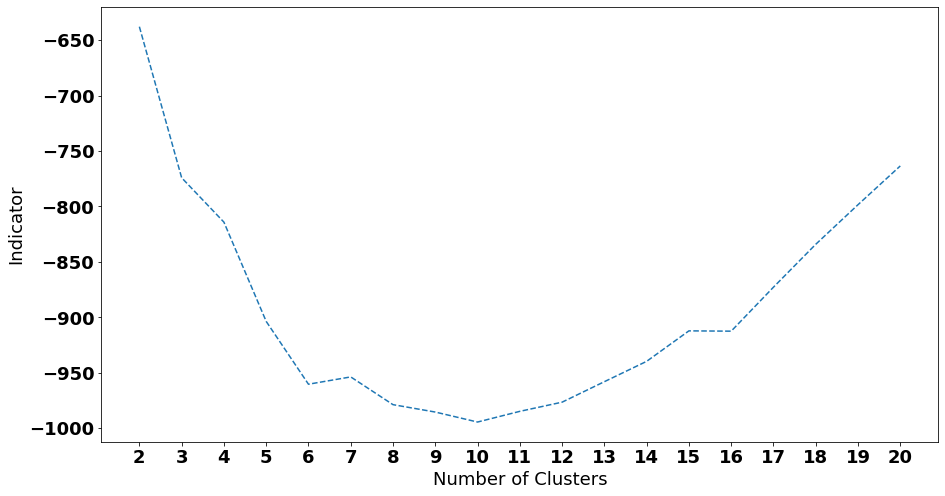

In [35]:
BIC_k = [i[0] for i in k_BIC]
k_list = [i[1] for i in k_BIC]
new_list = range(math.floor(min(k_list)), math.ceil(max(k_list))+1)

fig = plt.figure(figsize=(15, 8))

font = {'weight' : 'bold','size'   : 18}
plt.rc('font', **font)

plt.xticks(new_list)
plt.plot( k_list, BIC_k, linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Indicator")
plt.savefig('Indicator_Clusters.pdf')
plt.show()

# Typical time series profiles

In [36]:
Min_k_BIC = min(k_BIC)
optimum_k = Min_k_BIC[1]

final_labels, final_clustNum, dist, df, k, n = Hclustering(dist, df , optimum_k)

mean_Clustered_data = []

for i in range(0, final_clustNum):

    X = df[ClusterIndicesNumpy(i, final_labels)]
    
    std_clus = np.std(X, axis=0)
    mean_clus = np.mean(X, axis=0)
    
    typical_ts = mean_clus + std_clus
    
    mean_Clustered_data.append(typical_ts)

clustNum: 10
Hclustering.labels_: [6 0 0 4 4 5 2 2 2 2 0 4 2 2 2 2 2 9 9 2 2 2 2 2 0 4 4 3 7 7 7 0 9 3 3 7 7
 3 0 4 3 7 7 7 7 0 9 3 7 7 7 3 0 9 3 7 3 7 3 0 9 7 7 7 7 3 0 9 7 7 7 7 3 0
 9 3 3 3 1 1 0 9 1 1 8 2 2 9 6 5 5 5 5 5 4 6 5 5 5 5 6 4 6 6 5 5 5 5 4 6 5
 2 2 5 2 6 4 2 2 2 2 2 9 4 6 2 2 2 2 9 4 8 8 8 8 8 9 4 8 8 8 8 8 9 6 1 1 1
 3 1 0 6 1 1 1 1 1 9 4 1 1 1 1 1 0 4 1 1 1 1 1 0 4 1 1 1 1 1 0 4 2 2 2 2 2
 0 4 2 8 2 8 2 9 4 1 3 3 3 3 0 4 3 3 3 1 3 0 4 3 3 3 1 1 0 4 1 1 1 1 1 0 4
 5 1 1 1 8 0 4 1 3 3 1 1 0 4 1 3 1 1 1 0 4 1 1 1 1 2 0 4 1 3 3 1 1 0 9 1 3
 3 1 1 0 9 2 2 2 2 2 0 4 2 2 2 2 2 0 9 4 3 3 3 3 0 9 3 3 3 3 1 0 9 1 3 3 3
 3 0 9 7 3 3 3 3 0 9 3 3 3 3 1 0 9 3 3 3 3 3 0 9 3 3 3 3 3 0 9 3 3 3 3 3 0
 9 3 3 3 3 1 0 9 1 1 1 2 2 0 4 2 2 2 2 8 0 9 8 8 8 8 4 9 9 9 0 0 0]
No of days in each cluster: [43 64 53 73 31 17 11 23 19 32]


In [37]:
avg_clus_dat = pd.DataFrame(mean_Clustered_data)
avg_clus_dat = avg_clus_dat.T
avg_clus_dat

,0,1,2,3,4,5,6,7,8,9
0,256.694308,307.597740,306.452939,326.622028,240.824856,283.077437,236.541708,328.908260,292.310062,252.537692
1,262.556561,320.870030,321.934235,343.041952,241.669748,287.454721,241.144269,361.008957,303.260666,249.396853
2,269.240903,338.252412,335.349004,364.935500,245.738538,298.688361,242.509870,406.269354,314.412399,252.765164
3,275.783743,351.105416,342.252464,387.086744,249.334423,304.371968,243.539291,429.052746,327.651158,254.300220
4,279.086286,359.802203,354.870290,397.672404,248.786191,307.417365,245.577744,441.169954,327.375330,256.228043
5,279.462099,386.382445,369.632925,422.400433,256.304870,315.463162,247.947235,468.624111,356.066446,261.930804
6,288.621278,410.132297,375.186531,444.518314,257.935854,316.656503,248.579572,503.032050,366.237130,265.395008
7,303.744597,446.037122,378.583390,485.836241,266.701109,322.435722,251.083268,548.326680,383.850848,274.032670
8,316.298006,517.548351,387.640782,561.620357,268.694921,332.978367,252.126836,601.023744,414.942458,280.845452
9,334.897937,579.300135,393.745956,611.384270,273.357620,331.283108,259.480994,640.271060,461.508892,287.763302


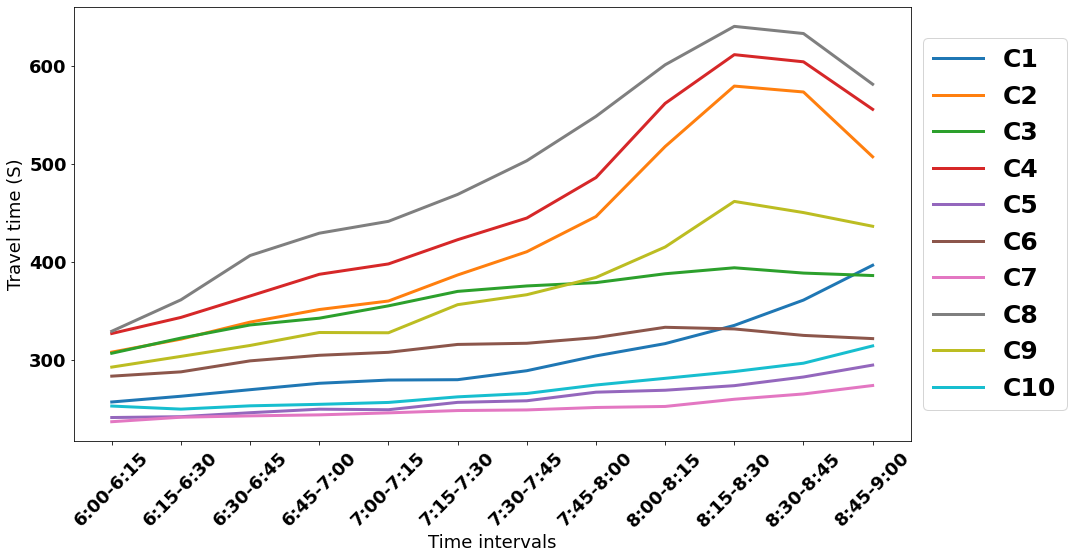

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))

xticklabels = ['6:00-6:15', '6:15-6:30', '6:30-6:45', '6:45-7:00', '7:00-7:15', '7:15-7:30','7:30-7:45', 
              '7:45-8:00', '8:00-8:15', '8:15-8:30','8:30-8:45','8:45-9:00']

avg_clus_dat.plot(ax=ax,lw=3, zorder=10)
plt.xticks(rotation=45)

plt.xlabel('Time intervals')
plt.ylabel('Travel time (S)')
SMALL_SIZE = 25
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize   

plt.legend(["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"],loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticklabels(xticklabels)
ax.set_xticks(np.arange(len(xticklabels)))

ax.patch.set_facecolor('w')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('black')

plt.show()

# Cluster box plots

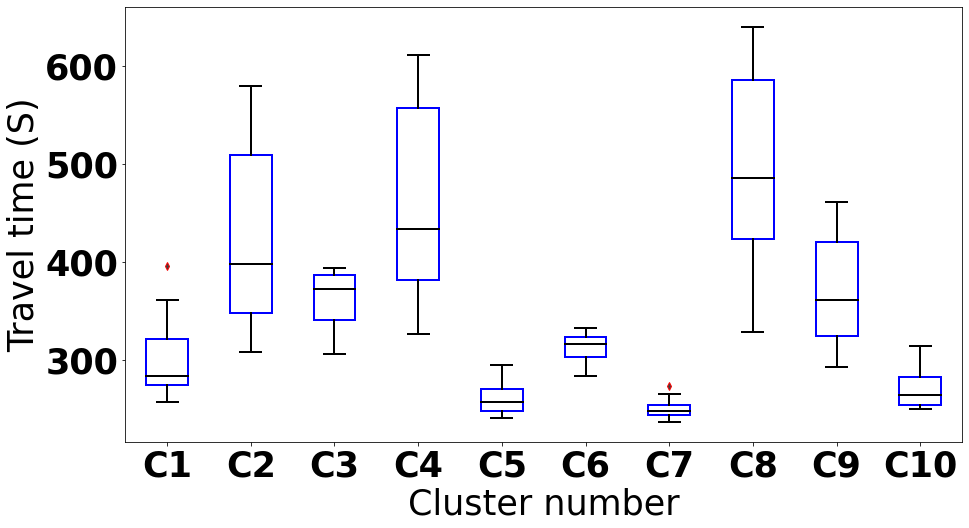

In [39]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

sns.boxplot(x="variable", y="value", data=pd.melt(avg_clus_dat), fliersize = 5, linewidth=2, width=0.5, ax=ax)

xticklabels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6','C7', 
              'C8', 'C9', 'C10']

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    artist.set_edgecolor('blue')
    artist.set_facecolor('None')
    
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        
        line = ax.lines[j]
        line.set_color('black')
        line.set_mfc('0.25')
        line.set_mec('red')
    
plt.ylabel('Travel time (S)')
plt.xlabel('Cluster number')
SMALL_SIZE = 10
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize   

ax.set(xticklabels=xticklabels)

plt.show()

# Cluster quality

In [40]:
data2 = pd.DataFrame(data1) #Converting data to dataframe
data3 = data2.drop([0, 1]) # Removing first two rows
data4 = data3.drop(data3.iloc[:, 0:2], axis=1) # Dropping first three columns
data5 = data4.T

In [41]:
k_s = []
for k in range(2,20):
    Clustered_data, labels, clustNum, dist, df,k,n = get_Clustered_data(df, dist, k)
    s = silhouette_score(data5, labels)
    k_s.append([k,s])

clustNum: 2
Hclustering.labels_: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
No of days in each cluster: [206 160]
clustNum: 3
Hclustering.labels_: [0 2 2 0 0 0 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2 2 2 2 0 0 1 1 1 1 2 0 1 1 1 1
 1 2 0 1 1 1 1 1 2 0 1 1 1 1 1 2 0 1 1 1 1 1 2 0 1 1 1 1 1 2 0 1 1 1 1 1 2
 0 

clustNum: 16
Hclustering.labels_: [ 6 10 10  8  8  0 13 13 13 13  2  8  5  5  5  5 13  4  4  5  5  5  5  5
  2  8  8  3 15 15 15  2  4 11 11 15 15  3  2  8 11 15 15 15 15  2  4 11
 15 15 15 11  2  4 11 15 11 15 11  2  4 15 15 15 15 11  2  4 15 15 15 15
 11  2  4 11 11 11  9 12 10  4 12  9  1 13 13  4  6  0  0  0  0  0  8  6
  0  0  0  0  6  8  6  6  0  0  0  0  8  6  0  7  7  0  7  6 14  7  7  7
  7  7  4 14  6 13 13 13 13  4  8  1  1  1  1  1  4 14  1  1  1  1  1  4
  6  9  9  9  3  9 10  6  9  9  9  9  9  4 14  9  9  9  9  9 10 14  9  9
  9  9  9 10  8  9  9  9  9  9 10 14  7  7  7  7 13 10 14  7  1 13  1 13
  4  8  9 11 11  3  3 10  8  3  3  3  9  3 10 14  3 11 11  9  9  2  8 12
  9  9  9  9  2  8  0  9  9  9  1 10  8 12  3  3  9  9  2  8  9  3  9  9
  9  2  8  9  9  9  9 13  2  8  9  3  3  9  9  2  4  9  3  3  9  9  2  4
 13 13  7 13 13  2  8 13 13 13 13 13  2  4  8 11 11 11  3  2  4  3 11 11
 11  9  2  4  9 11 11 11  3  2  4 15 11 11 11  3  2  4 11 11 11 11  9  2
  4 11 11 11 11  

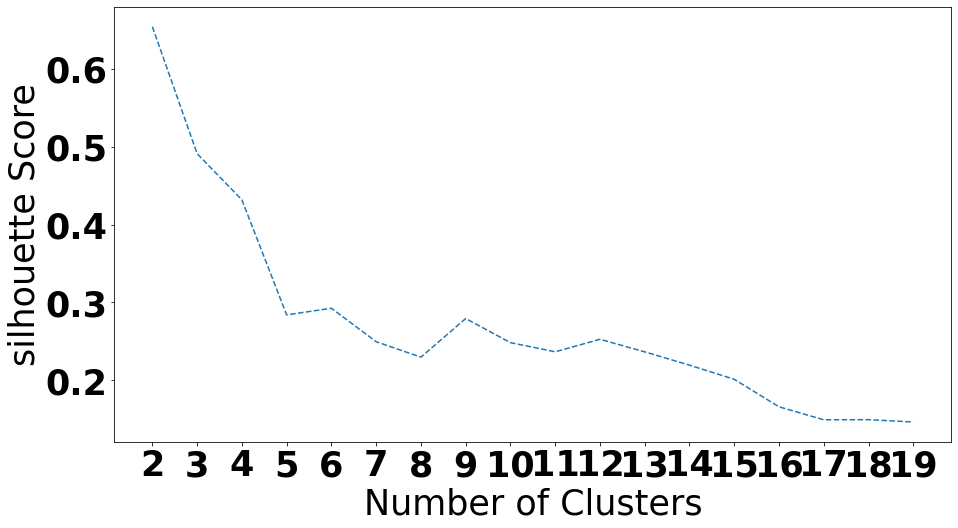

In [42]:
s_list = [i[1] for i in k_s]
k_list = [i[0] for i in k_s]

new_list = range(math.floor(min(k_list)), math.ceil(max(k_list))+1)

fig = plt.figure(figsize=(15, 8))

font = {'weight' : 'bold','size'   : 18}
plt.rc('font', **font)

plt.xticks(new_list)
plt.plot( k_list, s_list, linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette Score")
plt.savefig('Indicator_Clusters.pdf')
plt.show()

# Proportion of clusters plot

In [43]:
day_clus_id = pd.read_csv(r"C:\Users\n10387684\OneDrive - Queensland University of Technology\1_QUT\Codes\GitHub\TTR_AS\Data_Finucane road\Day_type_clus_ID.csv")

In [44]:
day_clus_id

,dayid,Date,Day,Status
0,0,43831,WEDNESDAY,PH
1,1,43832,THURSDAY,WDSH
2,2,43833,FRIDAY,WDSH
3,3,43834,SATURDAY,SATSH
4,4,43835,SUNDAY,SUNSH
...,...,...,...,...
360,360,44191,SATURDAY,LW
361,361,44192,SUNDAY,LW
362,362,44193,MONDAY,LW
363,363,44194,TUESDAY,WDSH


In [45]:
label_365 = final_labels[:-1]
day_clus_id['clus_id'] = label_365

In [46]:
day_clus_id

,dayid,Date,Day,Status,clus_id
0,0,43831,WEDNESDAY,PH,6
1,1,43832,THURSDAY,WDSH,0
2,2,43833,FRIDAY,WDSH,0
3,3,43834,SATURDAY,SATSH,4
4,4,43835,SUNDAY,SUNSH,4
...,...,...,...,...,...
360,360,44191,SATURDAY,LW,9
361,361,44192,SUNDAY,LW,9
362,362,44193,MONDAY,LW,9
363,363,44194,TUESDAY,WDSH,0


In [47]:
day_clus_id.to_csv(r"C:\Users\n10387684\OneDrive - Queensland University of Technology\1_QUT\Codes\GitHub\TTR_AS\Data_Finucane road\Day_type_clus_ID2.csv") 

# Creating meta data

In [48]:
End = datetime.now()
total_time = End - start
print( 'Total time: %s' %total_time)

Meta_data =  "Meta_Data" + file_extension
Meta_object = open(Meta_data, 'w')

append_prints(Meta_data, "_________________Time series clustering___________________")
append_prints(Meta_data, 'Maximum number of clusters: %s' %K_max)
append_prints(Meta_data, 'Number of days: %s' %N)
append_prints(Meta_data, "Analysis statrted at: %s" %format(start))
append_prints(Meta_data, 'End time: %s' %End)
append_prints(Meta_data, 'Total time: %s' %total_time)
append_prints(Meta_data, "Minimum BIC: %s" %Min_k_BIC[0])
append_prints(Meta_data, "Optimum K: %s" %Min_k_BIC[1])

Meta_object.close()

Total time: 1:13:14.433021


# Last cluster and its profiles

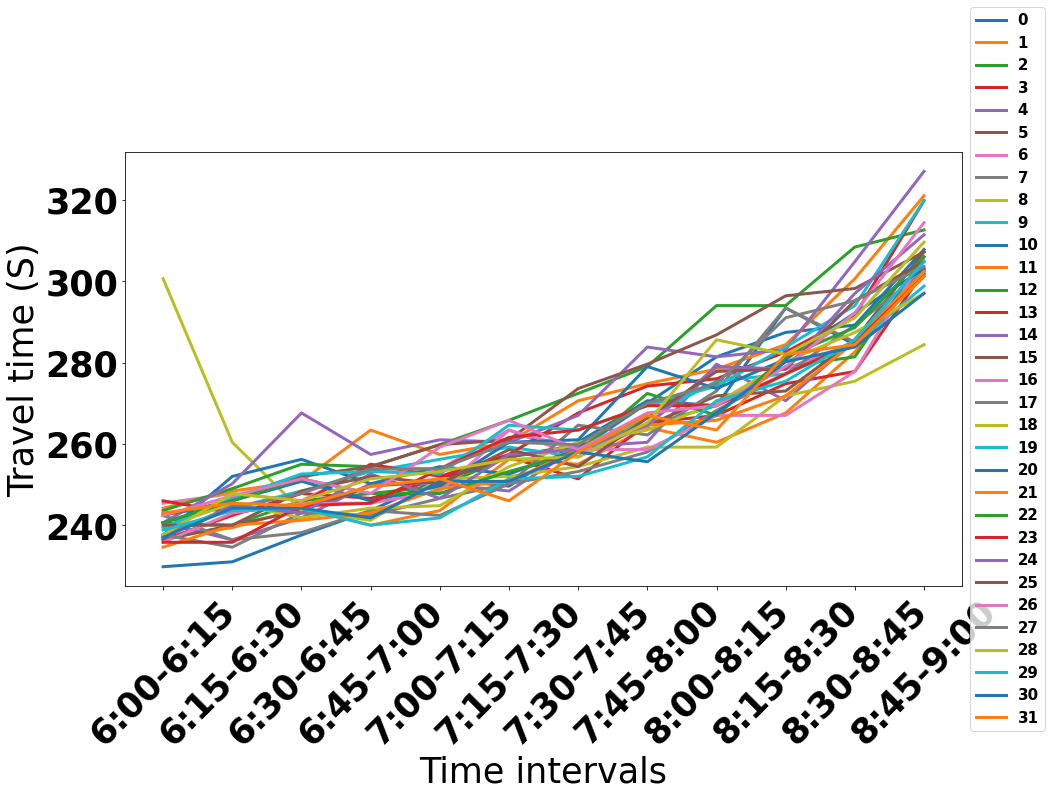

In [49]:
last_clust = pd.DataFrame(X)
last_clust = last_clust.T

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 25

fig, ax = plt.subplots(figsize=(15, 8))

xticklabels = ['6:00-6:15', '6:15-6:30', '6:30-6:45', '6:45-7:00', '7:00-7:15', '7:15-7:30','7:30-7:45', 
              '7:45-8:00', '8:00-8:15', '8:15-8:30','8:30-8:45','8:45-9:00']

last_clust.plot(ax=ax,lw=3, zorder=10)
plt.xticks(rotation=45)

plt.xlabel('Time intervals')
plt.ylabel('Travel time (S)')

plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

ax.set_xticklabels(xticklabels)
ax.set_xticks(np.arange(len(xticklabels)))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.patch.set_facecolor('w')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('black')

plt.show()

# KDE on cluster data

In [68]:
def kde_cluster(Clustered_data):
    '''
    Info: 
        Kernel density estimation for each cluster
    Inputs: 
        1) start time (ti), 
        2) end time (tj) , 
        3) (n,k) Array where samples of cluster i are at index i and, 
        shape of input array = (ni,K) where n is the number of samples in cluster i
    Outputs: 
        1) (K,n) Array of estimated kerner densities where K is the number of clusters
        2) (K,n) Array of grid points (interpolated samples) where K is the number of clusters
        output will have same number of samples for each cluster and,
        the number would depend on the grid size
    Iterator: 
        i will iterate over clusters (i in range of 0 to n-k)
    '''
    c_density = []
    c_support = []
    
    for i in range(len(Clustered_data)): #DF
        
        model = sm.nonparametric.KDEUnivariate(Clustered_data[i]) #DF
        model.fit()

        a = model.density/np.sum(model.density) #Normalizing the estimated density

        c_density.append(a) #Probability values
        c_support.append(model.support) #Measured quantity i.e., TT in this case    
    
    return c_density, c_support, Clustered_data

In [69]:
c_density, c_support, Clustered_data = kde_cluster(Clustered_data)

In [70]:
len(c_support)

8

In [74]:
c_density[3]

array([4.20102492e-07, 4.37988082e-07, 4.57915719e-07, ...,
       3.77860589e-07, 3.90116013e-07, 4.04171943e-07])

# Distribution plots for clusters 4, 5 and 8

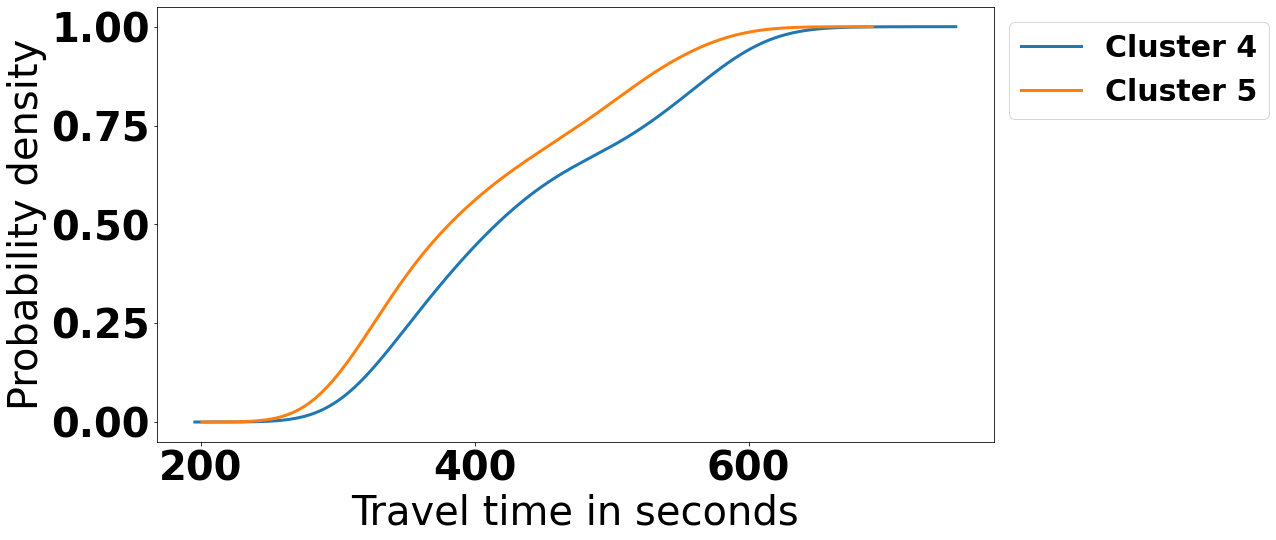

In [83]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
plt.xlabel('Travel time in seconds')
plt.ylabel('Probability density')

plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize   

y = np.cumsum(c_density[3])
x = c_support[3]

y_1 = np.cumsum(c_density[4])
x_1 = c_support[4]

ax.plot(x, y, lw=3, zorder=20, label='Cluster 4')
ax.plot(x_1, y_1, lw=3, zorder=20, label='Cluster 5')

# plt.xticks(np.arange(200, 400, 50))
# plt.yticks(np.arange(0, 0.005, 0.001))

plt.legend()
ax.legend(bbox_to_anchor=(1, 1))

# Cluster profiles

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

xticklabels = ['6:00-6:15', '6:15-6:30', '6:30-6:45', '6:45-7:00', '7:00-7:15', '7:15-7:30','7:30-7:45', 
              '7:45-8:00', '8:00-8:15', '8:15-8:30','8:30-8:45','8:45-9:00']

data2.plot(ax=ax,lw=3, zorder=10)
plt.xticks(rotation=20)

plt.xlabel('Time intervals')
plt.ylabel('Travel time (S)')

plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.patch.set_facecolor('w')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('black')

plt.show()